<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/04/cropped-Logo_Quantreo_transparent.png" align="left" hspace="10px" vspace="0px"></p>

# Portfolio Optimization
In this section you will learn the concept of portfolio management.
The idea is to combine our strategies to reduce the risk of your investment. The notions we will study apply to strategies as well as to assets. You will be able to create your own portfolio using the algorithms that we will present.

<br>

### Content
* Sortino Optimization
* Min Variance Optimization
* Mean Variance Skewness Kurtosis Optimization

### environnement

In [ ]:
!pip install ta
!pip install yfinance

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=2145b324be66eefd34fc13f661c25cd31de88640fdbaa9d958faef5705b51f8c
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta
     |████████████████████████████████| 6.3 MB 7.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=c7e8704f88b61cf357345c5d29658b66d044d39dcc78f14007f8aad8baf75947
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import ta
import yfinance as yf

import seaborn as sns
from tqdm import tqdm
import numpy as np
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

### Functions

In [ ]:
def RSI(val,neutral, window):
  """ 
        ------------------------------------------------------------------------------
        | Output: The function gives the returns of RSI strategy                     |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Entry values of the stock            |
        |         -neutral (float): Value of neutrality, i.e. no action zone         |
        |         -window (float): rolling period for RSI                            |
        ------------------------------------------------------------------------------
  """

  # Print Error if there is no column Adj Close in the dataframe
  if "Adj Close" not in val.columns:
    ValueError("We need have a columns name Adj Close because all computation are about this column")
  
  val["rsi"] = ta.momentum.RSIIndicator(val["Adj Close"], window=window).rsi()


  
  """ Long buy Signal """
  # We put threshold
  overbuy = 70
  neutral_buy = 50 + neutral

  # Put nan values for the signal long columns
  val["signal_long"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # We need define the Open Long signal (RSI yersteday<55 and RSI today>55)
  val.loc[(val["rsi"]>neutral_buy) & (val["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # We need define the Close Long signal (RSI yersteday>55 and RSI today<55) False signal
  val.loc[(val["rsi"]<neutral_buy)&(val["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # We need define the Close Long signal (RSI yersteday>70 and RSI today<70) Over buy signal
  val.loc[(val["rsi"]<overbuy)&(val["yersteday_rsi"]>overbuy), "signal_long"] = 0



  """Short sell signal """
  # We put threshold
  oversell = 30
  neutral_buy = 50 - neutral

  # Put nan values for the signal short columns
  val["signal_short"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # We need define the Open Short signal (RSI yersteday>45 and RSI today<45)
  val.loc[(val["rsi"]<neutral_buy) & (val["yersteday_rsi"]>neutral_buy), "signal_short"] = -1

  # We need define the Close Short signal (RSI yersteday<45 and RSI today>45) False signal
  val.loc[(val["rsi"]>neutral_buy)&(val["yersteday_rsi"]<neutral_buy), "signal_short"] = 0

  # We need define the Close Short signal (RSI yersteday<30 and RSI today>30) Over sell signal
  val.loc[(val["rsi"]>oversell)&(val["yersteday_rsi"]<oversell), "signal_short"] = 0


  """ Compute the returns """
  # Compute the percentage of variation of the asset
  val["pct"] = val["Adj Close"].pct_change(1)

  # Compute the positions
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Compute the return of the strategy
  val["return"] = val["pct"]*(val["Position"].shift(1))

  return val["return"]

In [ ]:
def drawdown_function(serie):
  
  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum()+1

  # We compute max of the cumsum on the period (accumulate max)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown  = cum/running_max - 1 
  return drawdown

In [ ]:
def BackTest(serie):

  # Import the benchmarcl
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  sp500.columns = ["SP500"]

  val = pd.concat((serie, sp500), axis=1).dropna()
  
  # Compute the drawdown
  drawdown = drawdown_function(serie)
  max_drawdown = -np.min(drawdown)

  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(15,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Put the cumsum
  cum.plot(serie.cumsum(), color="#39B3C7")
  cum.plot(val["Adj Close"].cumsum(), color="#B85A0F")
  cum.legend(["Portfolio", "SP500"])
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  # Plot the graph
  plt.show()

  # Compute the sortino
  sortino = np.sqrt(252)*serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val,rowvar=False)[0][1] /np.var(val["Adj Close"].dropna())

  # Compute the alpha
  alpha = 252*serie.mean() - 252*beta*serie.mean()

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha,3)}")
  print(f"MaxDrawdown: {np.round(max_drawdown*100,3)} %")


In [ ]:
def opt(f):
  # We set lists for the possible values of neutral and window
  neutral_values = [i*2 for i in range(10)]
  window_values = [i*2 for i in range(1,11)]

  # Set some Border of the datasets
  start_train, end_train = "2017-01-01", "2019-01-01"
  start_test, end_test = "2019-01-01", "2020-01-01"
  start_valid, end_valid = "2020-01-01", "2021-01-01"


  # Initialize the list
  resume = []

  # Loop to add the values in the list
  for i in range(len(neutral_values)):
      for j in range(len(window_values)):
        # Compute the returns
        return_train = RSI(f.loc[start_train:end_train], neutral_values[i], window_values[j])
        return_test = RSI(f.loc[start_test:end_test], neutral_values[i], window_values[j])

        # Compute the sortino
        sortino_train = np.sqrt(252) * return_train.mean() / return_train[return_train<0].std()
        sortino_test = np.sqrt(252) * return_test.mean() / return_test[return_test<0].std()

        # We do list of list to do a dataframe
        values = [neutral_values[i], window_values[j], sortino_train, sortino_test]
        resume.append(values)

  resume = pd.DataFrame(resume, columns=["Neutral", "Window", "Sortino Train", "Sortino test"])

  # Order by sortino
  ordered_resume = resume.sort_values(by="Sortino Train", ascending=False)



  for i in range(len(resume)):
    # Take the best
    best = ordered_resume.iloc[0+i:1+i,:]

    # Compute the sortino
    Strain = best["Sortino Train"].values[0]
    Stest = best["Sortino test"].values[0]

    # Take best neutral and best window
    best_neutral = best["Neutral"].values[0]
    best_window = best["Window"].values[0]

    # If the Sortino of the train and the test are good we stop the loop
    if Stest>0.5 and Strain>0.5:
      break

    # If there is no values enought good the put 0 in all values
    else:
      best_neutral = 0
      best_window = 0
      Strain = 0
      Stest = 0
  return [best_neutral, best_window, Strain, Stest]

# Section1:  Sortino Optimization

In [ ]:
# Import Yahoo name
assets = pd.read_csv("/content/Names.csv")["Symbol"]

# Initialize the lists
resume = []
col = []

# Compute best parameters for each Asset
for fin in tqdm(assets):

  # Import the asset
  arr = yf.download(fin)

  # Put the values
  resume.append(opt(arr))
  col.append(fin)



  0%|          | 0/152 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed


  1%|          | 1/152 [00:04<10:57,  4.35s/it]

[*********************100%***********************]  1 of 1 completed


  1%|▏         | 2/152 [00:08<10:38,  4.26s/it]

[*********************100%***********************]  1 of 1 completed


  2%|▏         | 3/152 [00:12<10:32,  4.24s/it]

[*********************100%***********************]  1 of 1 completed


  3%|▎         | 4/152 [00:16<10:20,  4.19s/it]

[*********************100%***********************]  1 of 1 completed


  3%|▎         | 5/152 [00:21<10:18,  4.21s/it]

[*********************100%***********************]  1 of 1 completed


  4%|▍         | 6/152 [00:25<10:13,  4.20s/it]

[*********************100%***********************]  1 of 1 completed


  5%|▍         | 7/152 [00:29<10:08,  4.20s/it]

[*********************100%***********************]  1 of 1 completed


  5%|▌         | 8/152 [00:33<10:02,  4.19s/it]

[*********************100%***********************]  1 of 1 completed


  6%|▌         | 9/152 [00:37<09:57,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


  7%|▋         | 10/152 [00:42<09:56,  4.20s/it]

[*********************100%***********************]  1 of 1 completed


  7%|▋         | 11/152 [00:46<09:49,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


  8%|▊         | 12/152 [00:50<09:45,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


  9%|▊         | 13/152 [00:54<09:39,  4.17s/it]

[*********************100%***********************]  1 of 1 completed


  9%|▉         | 14/152 [00:58<09:34,  4.16s/it]

[*********************100%***********************]  1 of 1 completed


 10%|▉         | 15/152 [01:02<09:28,  4.15s/it]

[*********************100%***********************]  1 of 1 completed


 11%|█         | 16/152 [01:07<09:35,  4.23s/it]

[*********************100%***********************]  1 of 1 completed


 11%|█         | 17/152 [01:11<09:30,  4.22s/it]

[*********************100%***********************]  1 of 1 completed


 12%|█▏        | 18/152 [01:15<09:23,  4.20s/it]

[*********************100%***********************]  1 of 1 completed


 12%|█▎        | 19/152 [01:19<09:22,  4.23s/it]

[*********************100%***********************]  1 of 1 completed


 13%|█▎        | 20/152 [01:24<09:20,  4.25s/it]

[*********************100%***********************]  1 of 1 completed


 14%|█▍        | 21/152 [01:28<09:19,  4.27s/it]

[*********************100%***********************]  1 of 1 completed


 14%|█▍        | 22/152 [01:32<09:12,  4.25s/it]

[*********************100%***********************]  1 of 1 completed


 15%|█▌        | 23/152 [01:36<09:06,  4.24s/it]

[*********************100%***********************]  1 of 1 completed


 16%|█▌        | 24/152 [01:41<09:00,  4.22s/it]

[*********************100%***********************]  1 of 1 completed


 16%|█▋        | 25/152 [01:45<08:53,  4.20s/it]

[*********************100%***********************]  1 of 1 completed


 17%|█▋        | 26/152 [01:49<08:40,  4.13s/it]

[*********************100%***********************]  1 of 1 completed


 18%|█▊        | 27/152 [01:53<08:30,  4.08s/it]

[*********************100%***********************]  1 of 1 completed


 18%|█▊        | 28/152 [01:57<08:23,  4.06s/it]

[*********************100%***********************]  1 of 1 completed


 19%|█▉        | 29/152 [02:01<08:24,  4.10s/it]

[*********************100%***********************]  1 of 1 completed


 20%|█▉        | 30/152 [02:05<08:18,  4.09s/it]

[*********************100%***********************]  1 of 1 completed


 20%|██        | 31/152 [02:09<08:08,  4.04s/it]

[*********************100%***********************]  1 of 1 completed


 21%|██        | 32/152 [02:13<08:01,  4.02s/it]

[*********************100%***********************]  1 of 1 completed


 22%|██▏       | 33/152 [02:17<07:52,  3.97s/it]

[*********************100%***********************]  1 of 1 completed


 22%|██▏       | 34/152 [02:21<07:46,  3.95s/it]

[*********************100%***********************]  1 of 1 completed


 23%|██▎       | 35/152 [02:25<07:49,  4.01s/it]

[*********************100%***********************]  1 of 1 completed


 24%|██▎       | 36/152 [02:29<07:47,  4.03s/it]

[*********************100%***********************]  1 of 1 completed


 24%|██▍       | 37/152 [02:33<07:48,  4.07s/it]

[*********************100%***********************]  1 of 1 completed


 25%|██▌       | 38/152 [02:37<07:43,  4.07s/it]

[*********************100%***********************]  1 of 1 completed


 26%|██▌       | 39/152 [02:41<07:36,  4.04s/it]

[*********************100%***********************]  1 of 1 completed


 26%|██▋       | 40/152 [02:45<07:27,  3.99s/it]

[*********************100%***********************]  1 of 1 completed


 27%|██▋       | 41/152 [02:49<07:25,  4.01s/it]

[*********************100%***********************]  1 of 1 completed


 28%|██▊       | 42/152 [02:53<07:24,  4.04s/it]

[*********************100%***********************]  1 of 1 completed


 28%|██▊       | 43/152 [02:57<07:22,  4.06s/it]

[*********************100%***********************]  1 of 1 completed


 29%|██▉       | 44/152 [03:01<07:20,  4.08s/it]

[*********************100%***********************]  1 of 1 completed


 30%|██▉       | 45/152 [03:05<07:17,  4.09s/it]

[*********************100%***********************]  1 of 1 completed


 30%|███       | 46/152 [03:09<07:09,  4.05s/it]

[*********************100%***********************]  1 of 1 completed


 31%|███       | 47/152 [03:14<07:08,  4.08s/it]

[*********************100%***********************]  1 of 1 completed


 32%|███▏      | 48/152 [03:18<07:04,  4.08s/it]

[*********************100%***********************]  1 of 1 completed


 32%|███▏      | 49/152 [03:22<06:59,  4.07s/it]

[*********************100%***********************]  1 of 1 completed


 33%|███▎      | 50/152 [03:26<06:54,  4.07s/it]

[*********************100%***********************]  1 of 1 completed


 34%|███▎      | 51/152 [03:30<07:00,  4.16s/it]

[*********************100%***********************]  1 of 1 completed


 34%|███▍      | 52/152 [03:34<07:00,  4.21s/it]

[*********************100%***********************]  1 of 1 completed


 35%|███▍      | 53/152 [03:39<06:56,  4.21s/it]

[*********************100%***********************]  1 of 1 completed


 36%|███▌      | 54/152 [03:43<06:50,  4.19s/it]

[*********************100%***********************]  1 of 1 completed


 36%|███▌      | 55/152 [03:47<06:42,  4.15s/it]

[*********************100%***********************]  1 of 1 completed


 37%|███▋      | 56/152 [03:51<06:37,  4.15s/it]

[*********************100%***********************]  1 of 1 completed


 38%|███▊      | 57/152 [03:55<06:37,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


 38%|███▊      | 58/152 [03:59<06:30,  4.15s/it]

[*********************100%***********************]  1 of 1 completed


 39%|███▉      | 59/152 [04:03<06:24,  4.13s/it]

[*********************100%***********************]  1 of 1 completed


 39%|███▉      | 60/152 [04:08<06:24,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


 40%|████      | 61/152 [04:12<06:24,  4.23s/it]

[*********************100%***********************]  1 of 1 completed


 41%|████      | 62/152 [04:16<06:16,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


 41%|████▏     | 63/152 [04:20<06:12,  4.19s/it]

[*********************100%***********************]  1 of 1 completed


 42%|████▏     | 64/152 [04:24<06:07,  4.17s/it]

[*********************100%***********************]  1 of 1 completed


 43%|████▎     | 65/152 [04:29<06:07,  4.22s/it]

[*********************100%***********************]  1 of 1 completed


 43%|████▎     | 66/152 [04:33<05:57,  4.16s/it]

[*********************100%***********************]  1 of 1 completed


 44%|████▍     | 67/152 [04:37<05:57,  4.21s/it]

[*********************100%***********************]  1 of 1 completed


 45%|████▍     | 68/152 [04:41<05:50,  4.17s/it]

[*********************100%***********************]  1 of 1 completed


 45%|████▌     | 69/152 [04:45<05:45,  4.16s/it]

[*********************100%***********************]  1 of 1 completed


 46%|████▌     | 70/152 [04:50<05:42,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


 47%|████▋     | 71/152 [04:54<05:42,  4.23s/it]

[*********************100%***********************]  1 of 1 completed


 47%|████▋     | 72/152 [04:58<05:38,  4.24s/it]

[*********************100%***********************]  1 of 1 completed


 48%|████▊     | 73/152 [05:02<05:33,  4.22s/it]

[*********************100%***********************]  1 of 1 completed


 49%|████▊     | 74/152 [05:07<05:28,  4.22s/it]

[*********************100%***********************]  1 of 1 completed


 49%|████▉     | 75/152 [05:11<05:22,  4.19s/it]

[*********************100%***********************]  1 of 1 completed


 50%|█████     | 76/152 [05:15<05:15,  4.16s/it]

[*********************100%***********************]  1 of 1 completed


 51%|█████     | 77/152 [05:19<05:10,  4.14s/it]

[*********************100%***********************]  1 of 1 completed


 51%|█████▏    | 78/152 [05:23<05:08,  4.17s/it]

[*********************100%***********************]  1 of 1 completed


 52%|█████▏    | 79/152 [05:27<05:05,  4.19s/it]

[*********************100%***********************]  1 of 1 completed


 53%|█████▎    | 80/152 [05:31<04:59,  4.17s/it]

[*********************100%***********************]  1 of 1 completed


 53%|█████▎    | 81/152 [05:36<04:57,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


 54%|█████▍    | 82/152 [05:40<04:51,  4.17s/it]

[*********************100%***********************]  1 of 1 completed


 55%|█████▍    | 83/152 [05:44<04:49,  4.19s/it]

[*********************100%***********************]  1 of 1 completed


 55%|█████▌    | 84/152 [05:48<04:46,  4.22s/it]

[*********************100%***********************]  1 of 1 completed


 56%|█████▌    | 85/152 [05:52<04:36,  4.13s/it]

[*********************100%***********************]  1 of 1 completed


 57%|█████▋    | 86/152 [05:56<04:34,  4.15s/it]

[*********************100%***********************]  1 of 1 completed


 57%|█████▋    | 87/152 [06:01<04:30,  4.17s/it]

[*********************100%***********************]  1 of 1 completed


 58%|█████▊    | 88/152 [06:05<04:27,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


 59%|█████▊    | 89/152 [06:09<04:21,  4.15s/it]

[*********************100%***********************]  1 of 1 completed


 59%|█████▉    | 90/152 [06:13<04:17,  4.16s/it]

[*********************100%***********************]  1 of 1 completed


 60%|█████▉    | 91/152 [06:17<04:12,  4.15s/it]

[*********************100%***********************]  1 of 1 completed


 61%|██████    | 92/152 [06:21<04:07,  4.12s/it]

[*********************100%***********************]  1 of 1 completed


 61%|██████    | 93/152 [06:26<04:05,  4.17s/it]

[*********************100%***********************]  1 of 1 completed


 62%|██████▏   | 94/152 [06:30<04:01,  4.16s/it]

[*********************100%***********************]  1 of 1 completed


 62%|██████▎   | 95/152 [06:34<03:58,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


 63%|██████▎   | 96/152 [06:38<03:56,  4.22s/it]

[*********************100%***********************]  1 of 1 completed


 64%|██████▍   | 97/152 [06:42<03:50,  4.19s/it]

[*********************100%***********************]  1 of 1 completed


 64%|██████▍   | 98/152 [06:46<03:43,  4.14s/it]

[*********************100%***********************]  1 of 1 completed


 65%|██████▌   | 99/152 [06:51<03:43,  4.21s/it]

[*********************100%***********************]  1 of 1 completed


 66%|██████▌   | 100/152 [06:55<03:36,  4.16s/it]

[*********************100%***********************]  1 of 1 completed


 66%|██████▋   | 101/152 [06:59<03:32,  4.17s/it]

[*********************100%***********************]  1 of 1 completed


 67%|██████▋   | 102/152 [07:03<03:26,  4.14s/it]

[*********************100%***********************]  1 of 1 completed


 68%|██████▊   | 103/152 [07:07<03:22,  4.12s/it]

[*********************100%***********************]  1 of 1 completed


 68%|██████▊   | 104/152 [07:11<03:18,  4.15s/it]

[*********************100%***********************]  1 of 1 completed


 69%|██████▉   | 105/152 [07:16<03:16,  4.19s/it]

[*********************100%***********************]  1 of 1 completed


 70%|██████▉   | 106/152 [07:20<03:09,  4.12s/it]

[*********************100%***********************]  1 of 1 completed


 70%|███████   | 107/152 [07:24<03:05,  4.13s/it]

[*********************100%***********************]  1 of 1 completed


 71%|███████   | 108/152 [07:28<03:01,  4.11s/it]

[*********************100%***********************]  1 of 1 completed


 72%|███████▏  | 109/152 [07:32<02:59,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


 72%|███████▏  | 110/152 [07:36<02:55,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


 73%|███████▎  | 111/152 [07:41<02:54,  4.25s/it]

[*********************100%***********************]  1 of 1 completed


 74%|███████▎  | 112/152 [07:45<02:49,  4.23s/it]

[*********************100%***********************]  1 of 1 completed


 74%|███████▍  | 113/152 [07:49<02:43,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


 75%|███████▌  | 114/152 [07:53<02:38,  4.16s/it]

[*********************100%***********************]  1 of 1 completed


 76%|███████▌  | 115/152 [07:57<02:33,  4.16s/it]

[*********************100%***********************]  1 of 1 completed


 76%|███████▋  | 116/152 [08:01<02:29,  4.15s/it]

[*********************100%***********************]  1 of 1 completed


 77%|███████▋  | 117/152 [08:06<02:28,  4.23s/it]

[*********************100%***********************]  1 of 1 completed


 78%|███████▊  | 118/152 [08:10<02:24,  4.24s/it]

[*********************100%***********************]  1 of 1 completed


 78%|███████▊  | 119/152 [08:14<02:17,  4.18s/it]

[*********************100%***********************]  1 of 1 completed


 79%|███████▉  | 120/152 [08:18<02:14,  4.21s/it]

[*********************100%***********************]  1 of 1 completed


 80%|███████▉  | 121/152 [08:23<02:09,  4.19s/it]

[*********************100%***********************]  1 of 1 completed


 80%|████████  | 122/152 [08:27<02:08,  4.29s/it]

[*********************100%***********************]  1 of 1 completed


 81%|████████  | 123/152 [08:31<02:04,  4.30s/it]

[*********************100%***********************]  1 of 1 completed


 82%|████████▏ | 124/152 [08:36<02:01,  4.34s/it]

[*********************100%***********************]  1 of 1 completed


 82%|████████▏ | 125/152 [08:40<01:56,  4.30s/it]

[*********************100%***********************]  1 of 1 completed


 83%|████████▎ | 126/152 [08:44<01:51,  4.30s/it]

[*********************100%***********************]  1 of 1 completed


 84%|████████▎ | 127/152 [08:49<01:47,  4.30s/it]

[*********************100%***********************]  1 of 1 completed


 84%|████████▍ | 128/152 [08:53<01:42,  4.27s/it]

[*********************100%***********************]  1 of 1 completed


 85%|████████▍ | 129/152 [08:57<01:38,  4.27s/it]

[*********************100%***********************]  1 of 1 completed


 86%|████████▌ | 130/152 [09:01<01:32,  4.22s/it]

[*********************100%***********************]  1 of 1 completed


 86%|████████▌ | 131/152 [09:05<01:28,  4.22s/it]

[*********************100%***********************]  1 of 1 completed


 87%|████████▋ | 132/152 [09:10<01:24,  4.22s/it]

[*********************100%***********************]  1 of 1 completed


 88%|████████▊ | 133/152 [09:14<01:19,  4.19s/it]

[*********************100%***********************]  1 of 1 completed


 88%|████████▊ | 134/152 [09:18<01:13,  4.10s/it]

[*********************100%***********************]  1 of 1 completed


 89%|████████▉ | 135/152 [09:22<01:10,  4.12s/it]

[*********************100%***********************]  1 of 1 completed


 89%|████████▉ | 136/152 [09:26<01:05,  4.11s/it]

[*********************100%***********************]  1 of 1 completed


 90%|█████████ | 137/152 [09:30<01:01,  4.12s/it]

[*********************100%***********************]  1 of 1 completed


 91%|█████████ | 138/152 [09:34<00:56,  4.05s/it]

[*********************100%***********************]  1 of 1 completed


 91%|█████████▏| 139/152 [09:38<00:52,  4.07s/it]

[*********************100%***********************]  1 of 1 completed


 92%|█████████▏| 140/152 [09:42<00:48,  4.06s/it]

[*********************100%***********************]  1 of 1 completed


 93%|█████████▎| 141/152 [09:46<00:44,  4.08s/it]

[*********************100%***********************]  1 of 1 completed


 93%|█████████▎| 142/152 [09:50<00:40,  4.09s/it]

[*********************100%***********************]  1 of 1 completed


 94%|█████████▍| 143/152 [09:54<00:36,  4.10s/it]

[*********************100%***********************]  1 of 1 completed


 95%|█████████▍| 144/152 [09:58<00:32,  4.07s/it]

[*********************100%***********************]  1 of 1 completed


 95%|█████████▌| 145/152 [10:03<00:28,  4.09s/it]

[*********************100%***********************]  1 of 1 completed


 96%|█████████▌| 146/152 [10:07<00:24,  4.09s/it]

[*********************100%***********************]  1 of 1 completed


 97%|█████████▋| 147/152 [10:11<00:20,  4.12s/it]

[*********************100%***********************]  1 of 1 completed


 97%|█████████▋| 148/152 [10:15<00:16,  4.11s/it]

[*********************100%***********************]  1 of 1 completed


 98%|█████████▊| 149/152 [10:19<00:12,  4.12s/it]

[*********************100%***********************]  1 of 1 completed


 99%|█████████▊| 150/152 [10:23<00:08,  4.17s/it]

[*********************100%***********************]  1 of 1 completed


 99%|█████████▉| 151/152 [10:27<00:04,  4.13s/it]

[*********************100%***********************]  1 of 1 completed


100%|██████████| 152/152 [10:31<00:00,  4.16s/it]


In [ ]:
# Add asset columns to each list of resume
for i in range(len(resume)):
  resume[i].append(col[i])

# Create a dataframe
res = pd.DataFrame(resume, columns=["Neutral", "Window", "Train", "Test", "Asset"])

# Indexig by asset
res = res.set_index("Asset")
res

,Neutral,Window,Train,Test
Asset,,,,
EURUSD=X,0,0,0.000000,0.000000
EURGBP=X,0,0,0.000000,0.000000
EURCHF=X,0,0,0.000000,0.000000
EURCAD=X,0,0,0.000000,0.000000
EURCNY=X,0,0,0.000000,0.000000
...,...,...,...,...
TCOM,14,4,1.348638,1.762285
INCY,0,0,0.000000,0.000000
CHKP,0,0,0.000000,0.000000


In [ ]:
# Order the dataframe using the Train sortino
values = res.sort_values(by="Train", ascending=False)
values.head(20)

,Neutral,Window,Train,Test
Asset,,,,
MRNA,10,4,67.114532,0.519912
BSV-USD,4,2,4.165631,2.001604
BNB-USD,12,8,4.164220,1.113779
BCH-USD,16,6,3.524647,0.739881
ADA-USD,8,6,3.299248,0.707319
XRP-USD,10,2,3.156333,0.509452
MIOTA-USD,6,2,2.867645,0.663595
XLM-USD,10,2,2.799206,1.379741
ALGN,2,6,2.664059,2.348276


In [ ]:
# Border of sets
start_train, end_train = "2017-01-01", "2019-01-01"
start_test, end_test = "2019-01-01", "2020-01-01"
start_valid, end_valid = "2020-01-01", "2021-01-01"

# Create a dataframe to put the strategies (The assets of the portfolio)
strategies = pd.DataFrame()
for col in values.index[0:15]:
  
  # Import the asset
  l = yf.download(col)

  # Extract opptimal neutral
  best_neutral = values.loc[col]["Neutral"]

  # Exctract optimal window
  best_window = values.loc[col]["Window"]
  
  strategies[f"{col}"] = RSI(l.loc[start_train:],best_neutral,int(best_window))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
strategies

,MRNA,BSV-USD,BNB-USD,BCH-USD,ADA-USD,XRP-USD,MIOTA-USD,XLM-USD,ALGN,ETH-USD,DOGE-USD,NTES,NEO-USD,USDMYR=X,LINK-USD
Date,,,,,,,,,,,,,,,
2018-12-07,NaN,0.001796,0.085433,0.006880,0.030327,-0.000000,-0.000000,0.036214,0.041306,0.000000,-0.003338,-0.007800,-0.004871,-0.002481,0.028123
2018-12-10,NaN,0.021510,-0.000000,0.021016,-0.000000,-0.000000,-0.050029,-0.048863,-0.030341,-0.000000,0.000951,0.000000,-0.045196,0.000000,-0.000000
2018-12-11,NaN,0.053242,-0.048477,0.048840,-0.000000,0.007970,0.028955,0.045817,-0.016662,-0.000000,0.005714,0.000000,0.044149,0.000000,0.000000
2018-12-12,NaN,0.015527,0.000000,-0.005087,0.000000,-0.019838,-0.033595,-0.007577,-0.000000,0.000000,-0.011015,0.000000,-0.034849,0.000000,0.000000
2018-12-13,NaN,0.117870,-0.000000,0.119794,-0.000000,-0.023744,0.000000,0.069399,0.009394,-0.000000,0.021791,0.000000,-0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-14,0.000000,0.017789,0.000000,-0.040371,0.002093,-0.029958,0.000000,-0.036990,0.005952,-0.043725,0.000000,0.041506,-0.069959,0.000000,-0.142195
2021-09-15,0.000000,-0.018069,0.000000,0.000000,-0.044246,0.000000,0.035228,0.031369,-0.005464,0.000000,0.000000,-0.005206,0.014751,0.000000,0.001087
2021-09-16,0.000000,0.006535,-0.000000,-0.000000,-0.000000,-0.026624,-0.053906,-0.031812,-0.025313,-0.012167,-0.000000,0.007298,-0.036932,-0.000000,-0.030964


In [ ]:
strategies = strategies.iloc[:,1:]

In [ ]:
def SR_criterion(weight, returns):
  """ 
  ------------------------------------------------------------------------------
  | Output: Opposite Sortino ratio to do a m imization                          |
  ------------------------------------------------------------------------------
  | Inputs: -Weight (type ndarray numpy): Wheight for portfolio                |
  |         -returns (type dataframe pandas): Returns of stocks                |
  ------------------------------------------------------------------------------
  """
  pf_return = returns.values.dot(weight)
  mu = np.mean(pf_return) 
  sigma = np.std(pf_return[pf_return<0])
  Sortino = -mu/sigma
  return Sortino




n=len(strategies.transpose())

# Initialisation weight value
x0 = np.zeros(n)+(1/n)

# Optimization constraints problem
cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

Bounds= [(0 , 1) for i in range(0,n)]


# Optimization problem solving
res_SR = minimize(SR_criterion, x0, method="SLSQP", args=(strategies.loc[start_train:end_test].dropna()),bounds=Bounds,constraints=cons,options={'disp': False})

# Result for visualization

# Result for computations
X = res_SR.x


[*********************100%***********************]  1 of 1 completed


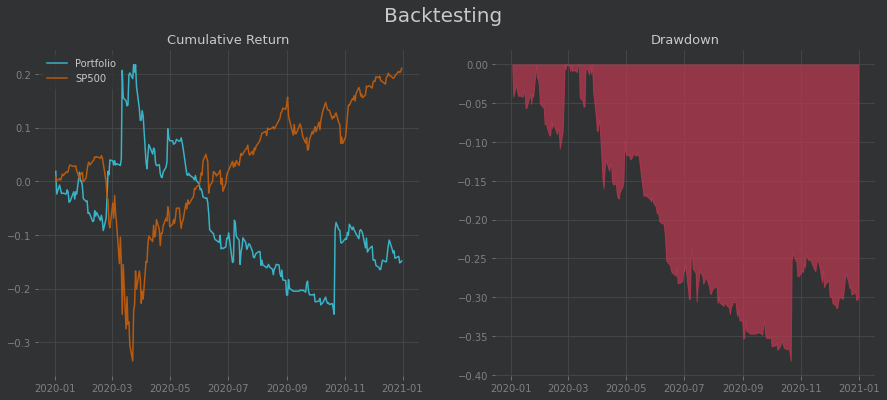

Sortino: -0.754
Beta: -0.171
Alpha: -0.173
MaxDrawdown: 38.215 %


In [ ]:
# BackTest Sortino Optimization
sr = np.multiply(strategies.loc[start_valid:end_valid], X).sum(axis=1)
BackTest(sr)

# Section 2: Min Variance Optimization

In [ ]:
def MV_criterion(weight,Returns_data):
  """ 
  ------------------------------------------------------------------------------
  | Output: optimization porfolio criterion                                    |
  ------------------------------------------------------------------------------
  | Inputs: -weight (type ndarray numpy): Wheight for portfolio                |
  |         -Returns_data (type ndarray numpy): Returns of stocks              |
  ------------------------------------------------------------------------------
  """
  portfolio_return=np.multiply(Returns_data,np.transpose(weight));
  portfolio_return=np.sum(portfolio_return,1);
  mean_ret=np.mean(portfolio_return,0)
  sd_ret=np.std(portfolio_return,0)
  criterion = sd_ret
  return criterion




n=len(strategies.transpose())
# Initialisation weight value
x0 = np.zeros(n)+(1/n)

# Optimization constraints problem
cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

Bounds= [(0 , 1) for i in range(0,n)]


# Optimization problem solving
res_SR = minimize(MV_criterion, x0, method="SLSQP", args=(strategies.loc[start_train:end_test].dropna()),bounds=Bounds,constraints=cons,options={'disp': False})

# Result for visualization

# Result for computations
X = res_SR.x

[*********************100%***********************]  1 of 1 completed


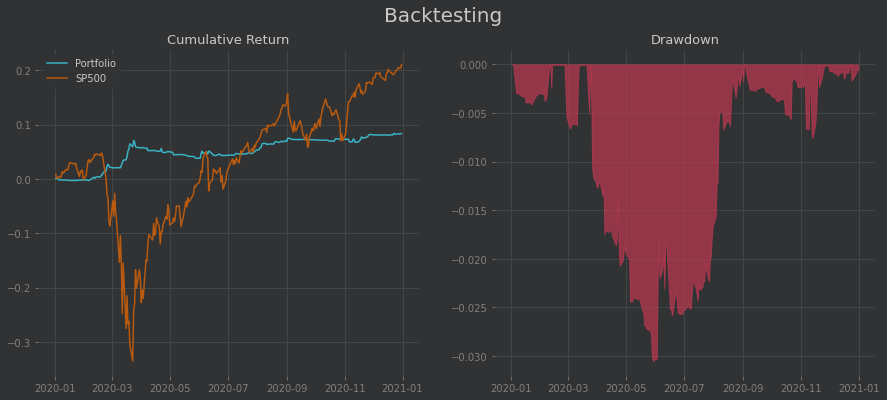

Sortino: 3.444
Beta: -0.006
Alpha: 0.084
MaxDrawdown: 3.051 %


In [ ]:
# BackTest MinVar Optimization
mv = np.multiply(strategies.loc[start_valid:end_valid], X).sum(axis=1)
BackTest(mv)

# Section3: Mean Variance Skewness Kurtosis Optimization

In [ ]:
def SK_criterion(weight,Returns_data):
  """ 
  ------------------------------------------------------------------------------
  | Output: optimization porfolio criterion                                    |
  ------------------------------------------------------------------------------
  | Inputs: -weight (type ndarray numpy): Wheight for portfolio                |
  |         -Returns_data (type ndarray numpy): Returns of stocks              |
  ------------------------------------------------------------------------------
  """
  from scipy.stats import skew, kurtosis

  Lambda_RA = 3
  portfolio_return=np.multiply(Returns_data,np.transpose(weight));
  portfolio_return=np.sum(portfolio_return,1);
  mean_ret=np.mean(portfolio_return,0)
  sd_ret=np.std(portfolio_return,0)
  skew_ret=skew(portfolio_return,0)
  kurt_ret=kurtosis(portfolio_return,0)
  W=1;
  Wbar=1*(1+0.25/100);
  criterion=np.power(Wbar,1-Lambda_RA)/(1+Lambda_RA)+np.power(Wbar,-Lambda_RA)*W*mean_ret-Lambda_RA/2*np.power(Wbar,-1-Lambda_RA)*np.power(W,2)*np.power(sd_ret,2)+Lambda_RA*(Lambda_RA+1)/(6)*np.power(Wbar,-2-Lambda_RA)*np.power(W,3)*skew_ret-Lambda_RA*(Lambda_RA+1)*(Lambda_RA+2)/(24)*np.power(Wbar,-3-Lambda_RA)*np.power(W,4)*kurt_ret
  criterion=-criterion;
  return criterion



n=len(strategies.transpose())
# Initialisation weight value
x0 = np.zeros(n)+(1/n)

# Optimization constraints problem
cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

Bounds= [(0 , 1) for i in range(0,n)]


# Optimization problem solving
res_SR = minimize(SK_criterion, x0, method="SLSQP", args=(strategies.loc[start_train:end_test].dropna()),bounds=Bounds,constraints=cons,options={'disp': False})

# Result for visualization

# Result for computations
X = res_SR.x


[*********************100%***********************]  1 of 1 completed


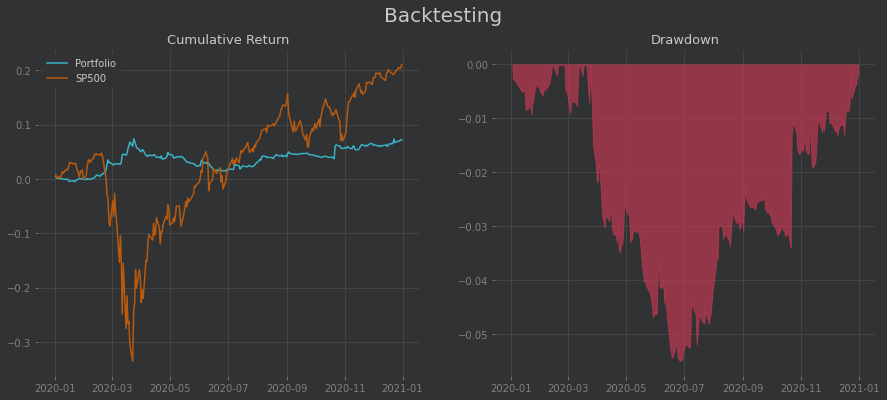

Sortino: 2.496
Beta: -0.009
Alpha: 0.072
MaxDrawdown: 5.497 %


In [ ]:
# Plot the performances
s = np.multiply(strategies.loc[start_valid:end_valid], X).sum(axis=1)
BackTest(s)